In [1]:
# Imports
%matplotlib notebook
# numpy, matplotlib, seaborn and matplotlib
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# define data path
INPUT_PATH = "../data/%s.csv"
# define small samples to quickly explore data
read_rows = 300;

# Overview Part
This part is to overview the first N rows of the sample to get initial feeling of the dataset

In [ ]:
# load data head for overview
train_date_overview = pd.read_csv('../data/train_date.csv',nrows = read_rows)
train_categorical_overview = pd.read_csv('../data/train_categorical.csv',nrows = read_rows)
train_numeric_overview = pd.read_csv('../data/train_numeric.csv',nrows = read_rows)
test_categorical_overview = pd.read_csv('../data/test_categorical.csv', nrows = read_rows)
test_date_overview = pd.read_csv('../data/test_date.csv', nrows = read_rows)
test_numeric_overview = pd.read_csv('../data/test_numeric.csv', nrows = read_rows)

In [ ]:
#train_numeric_overview
#train_categorical_overview
#train_date_overview
#test_numeric_overview
#test_categorical_overview
#test_date_overview 

# General Feature Exploration Part
This part is to explore the common feature

In [ ]:
# function to calculate failure rate
def get_failure_rate(file_name):
    # will calculate the error rate from data on the file based on response col
    # Respons: 1 = Failed QC , 0 = Passed QC
    rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Response"])
    failure_rate = rows[rows.Response == 1].size / float(rows[rows.Response == 0].size)
    return failure_rate

In [ ]:
# function to calculate data size in 6 dataset
def explore_data_size():
    # explore the size (rows, cols) of each file
    data_files = ['train_numeric', 'train_date', 'train_categorical', 'test_numeric',
                  'test_date', 'test_categorical']
    stats = []
    for file_name in data_files:
        cols = pd.read_csv(INPUT_PATH % file_name, nrows=1)
        rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Id"])
        stats.append({'File': file_name, 'Rows': rows.shape[0], 'Columns': cols.shape[1]})
    # convert the result into a DataFrame so we can do plotting.
    df = pd.DataFrame(stats, columns=["File", "Rows", "Columns"])
    failure_rate = get_failure_rate('train_numeric')
    df["Error"] = 0
    df.loc[df.File == 'train_numeric', 'Error'] = failure_rate
    return df

In [ ]:
# Get data size
explore_data_size()

# Numerical Feature Exploration Part

In [2]:
def get_number_features(station_features):
    total_features = 0
    for key in station_features.keys():
        total_features += len(station_features[key]) 
    return total_features

def get_features(feature_list):
    # function to group features by station or line of production the convention is:
    # L1_S15_F232 means Line 1, Station 15, Feature 232
    line_features = {}
    station_features = {}
    lines = set([item.split('_')[0] for item in feature_list])
    stations = set([item.split('_')[1] for item in feature_list])

    for l in lines:
        line_features[l] = [item for item in feature_list if '%s_' % l in item]

    for s in stations:
        station_features[s] = [item for item in feature_list if '%s_' % s in item]
    
    print 'No. of lines: '+ str(len(lines))
    print 'No. of stations: '+ str(len(stations))
    print 'No. of features: '+ str(int(get_number_features(station_features)))
    

    return (line_features, station_features)

In [3]:
def explore_features(data_set_name,is_response):
    # how many units processed in each station
    # also percentage of failed/passed QS in each station
    if is_response :
        features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    else:
        features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Id"], axis=1).columns.values
    
    line_features, station_features = get_features(features)
    # create a dataframe cols: station, features_count
    sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])
    ldf = pd.DataFrame(list({int(key[1:]): len(line_features[key]) for
                             key in line_features.keys()}.items()),
                       columns=["Line", "FeatureCount"])
    
    stations_plot = sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Fig.1 - Features by Station",
                             figsize=(13,6), fontsize=12)
    
    line_features_plot = ldf.plot(x="Line",y="FeatureCount", kind="bar",
                             title="Fig.2 - Features by line",
                             figsize=(13,6), fontsize=12)
    
    #print 'No. of features:'+ str(int(get_number_features(station_features)))
    
    return line_features, station_features

In [ ]:
lf, sf = explore_features("train_numeric",True)

This part is to see how many parts per station, how many success and failure parts per station

In [ ]:
def explore_product_by_station(data_set_name,read_rows):
    # need to see how many product per station
    # features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    # line_features, station_features = get_features(features)
    station_features = sf
    dwb_result = []
    ppbs_result = []
    rows = 0
    # inside this loop we will try to calculate different data sets, this way we only read the
    # files once since it takes a while and produce multiple results
    for station in station_features:
        station_data = pd.read_csv(
            INPUT_PATH % data_set_name,
            usecols=station_features[station] + ['Id', 'Response'],nrows = read_rows)
        
        # need to get how many rows in the sample row
        if not rows:
            rows = station_data.shape[0]
        # need to store how many processed units in each station
        # only if all features in that station has value we conside unit processed in this station
        ppbs_result.append(
            {'Station': int(station[1:]),
             'Processed': station_data[station_features[station]].notnull().all(axis=1).sum()})
        
        # data without blanks (dwb): take all rows and drop any row that has any blank
        # in any station column
        dwb = station_data.dropna(how="any")
        dwb_result.append([int(station[1:]), dwb.shape[0],
                       dwb[dwb["Response"] == 1].shape[0],
                       dwb[dwb["Response"] == 0].shape[0]])
        
    # convert list to a dataframe and prepare for the plot
    dwb_df = pd.DataFrame(
        dwb_result, columns=["Station", "Count", "Failed", "Passed"]).sort_values(by=["Station"])
    # calculate the error rate for each station
    dwb_df["Error"] = dwb_df.apply(lambda row: float(row["Failed"]) / (row["Count"] + 1), axis=1)
    
    # plot the stacked bar tot product/ station
    my_plot = dwb_df[["Station", "Failed", "Passed"]].plot(kind="bar", stacked=True, x="Station",
        title="Fig:3 - Products by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Record Count")
    
    # plot error rate per station
    my_plot = dwb_df[["Station", "Error"]].plot(
        kind="bar", x="Station",
        title="Fig:4 - Error by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Error %")
    
    # process the ppbs result to see how many products has been process by each station.
    ppbs_df = pd.DataFrame(
        ppbs_result, columns=['Station', 'Processed']).sort(columns=['Station'])
    # calculate the missed product for each station: all count - processed count
    ppbs_df["Missed"] = ppbs_df["Processed"].apply(lambda x: rows - x)
    # the plot
    ppbs_df.plot(x="Station", kind="bar", stacked=True,
            title="Fig: 5 - Products processed by each station",
            figsize=(13,6), fontsize=12)
    



In [ ]:
explore_product_by_station("train_numeric",300)

# Categorial Data Exploration Part

No. of lines: 4
No. of stations: 34
No. of features: 2140


<IPython.core.display.Javascript object>


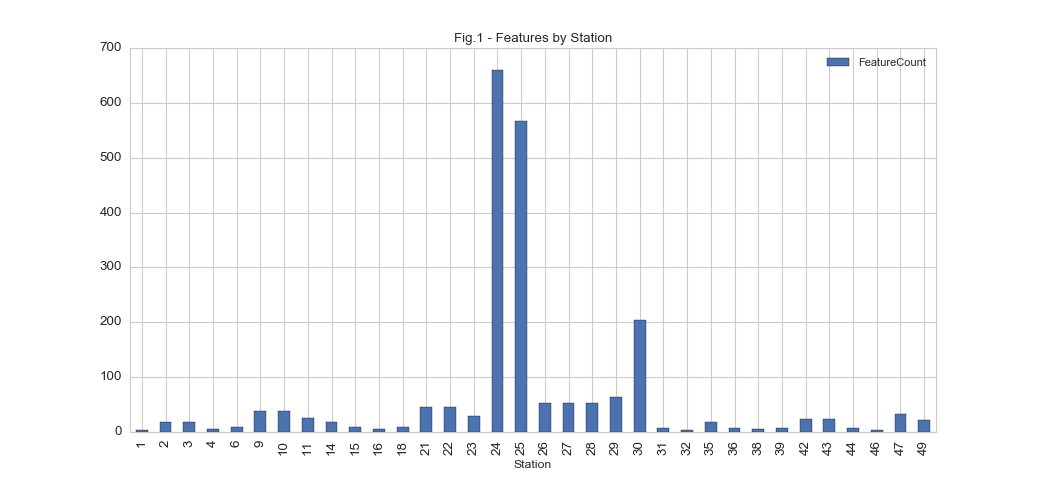

<IPython.core.display.Javascript object>

In [4]:
lf, sf = explore_features("train_categorical",False)

In [22]:
# this function is to explore sparsity rate per row
def explore_sparse_rate(data_set_name, read_rows):
    train_categorical = pd.read_csv(INPUT_PATH % data_set_name,nrows = read_rows).drop(["Id"], axis=1)
    sparse_rate_each_part = []
    sparse_rate_series = train_categorical.isnull().sum(axis = 1)/train_categorical.shape[1]
    sparse_rate_df = pd.DataFrame(
        sparse_rate_series, columns=['sparse_rate'])
    return sparse_rate_df

In [ ]:
explore_sparse_rate('train_categorical', 100)

In [34]:
# This function is to get feeling of the TX value in the dataset
def explore_dintinct_Tx_value(data_set_name, read_rows):
    train_categorical = pd.read_csv(INPUT_PATH % 'train_categorical',nrows = read_rows)
    del train_categorical['Id']
    train_categorical_zeroes = train_categorical.fillna(0)
    train_categorical_zeroes = train_categorical_zeroes.values 
    return np.unique(train_categorical_zeroes[train_categorical_zeroes!=0.0])

In [35]:
explore_dintinct_Tx_value('train_categorical', 30)

array(['T1', 'T145', 'T3', 'T4'], dtype=object)